1.) Preparación del Environment, dependencias, e importación de modulos.

In [1]:
#Instalamos las librerias base a nuestro proyecto-environment.
#pip install numpy pandas matplotlib seaborn xgboost scikit-learn
#!pip install scikit-learn

In [ ]:

# Guardamos las dependencias actuales del entorno en el archivo requirements.txt.
# Si se instalan nuevas librerías más adelante, se debe volver a ejecutar este comando para actualizar el archivo.
# Esto permite que otros usuarios puedan replicar el entorno con: pip install -r requirements.txt
#!pip freeze > requirements.txt



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

2.) Lectura de los datos. En este caso, se trata de un dataset de consumo energético a lo largo de los años, según la AEP. (American Electric Power.) 

In [3]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [4]:
df.describe

<bound method NDFrame.describe of                       AEP_MW
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0
...                      ...
2018-01-01 20:00:00  21089.0
2018-01-01 21:00:00  20999.0
2018-01-01 22:00:00  20820.0
2018-01-01 23:00:00  20415.0
2018-01-02 00:00:00  19993.0

[121273 rows x 1 columns]>

In [5]:

# Verificar si el índice está ordenado
print(df.index.is_monotonic_increasing)

# Verificar duplicados en el índice
print(df.index.duplicated().sum())

# Ordenar el índice si es necesario
df = df.sort_index()

False
4


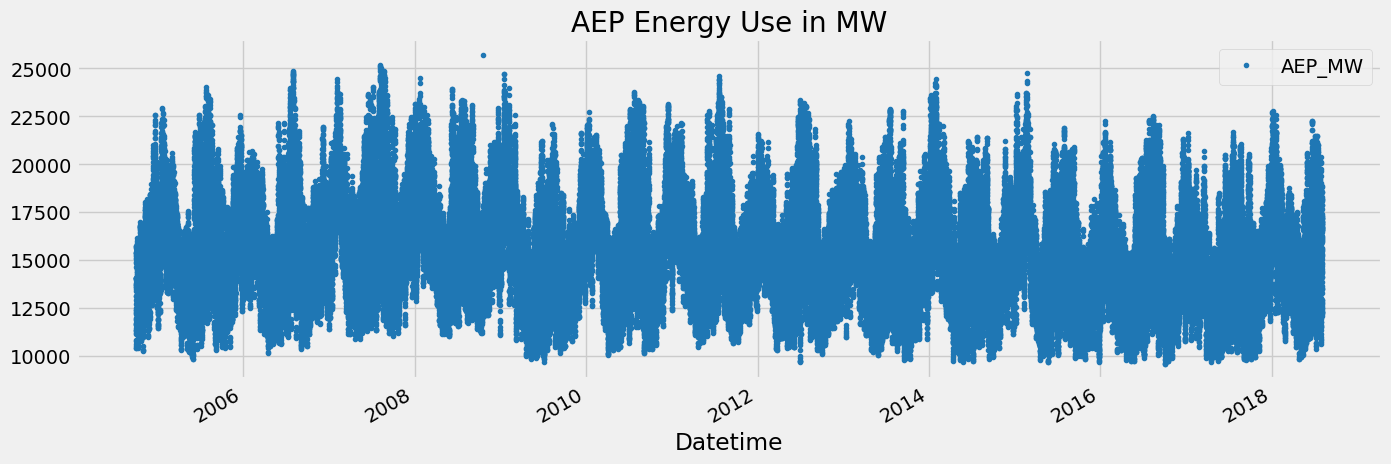

In [6]:
#Un pequeño gráfico para la previsualización de los datos y observar su distribución.
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='AEP Energy Use in MW')
plt.show()

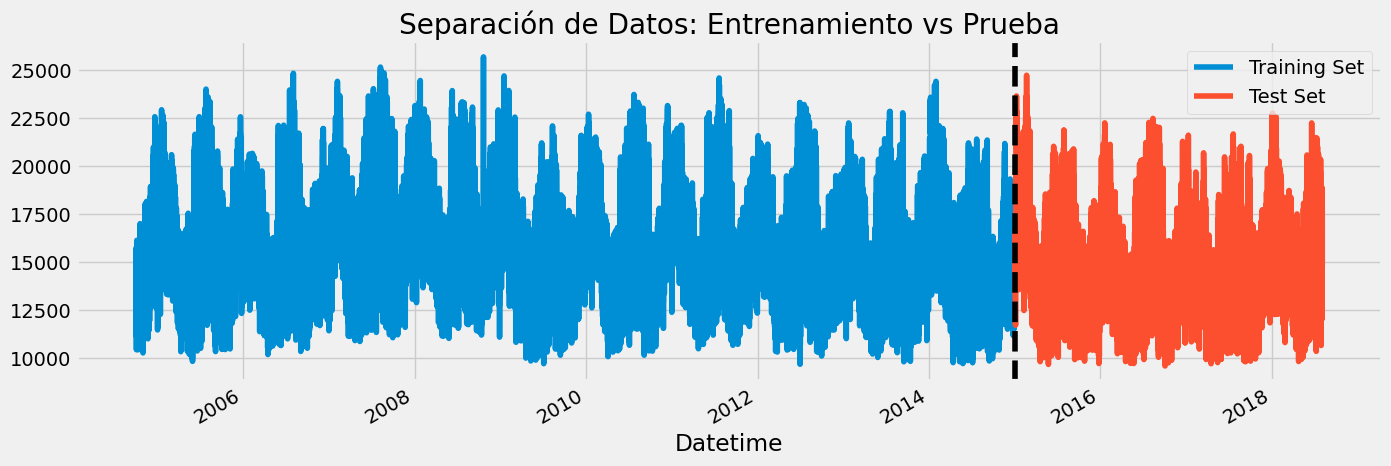

In [7]:

# Visualización de la distribución temporal de los datos de entrenamiento y prueba.
# El conjunto de datos abarca un periodo de 14 años, de los cuales aproximadamente el 20% (3 años)
# se reserva para pruebas, comenzando desde el 1 de enero de 2015.

# División del DataFrame en conjuntos de entrenamiento y prueba
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

# Creación de la figura para la visualización
fig, ax = plt.subplots(figsize=(15, 5))

# Graficar ambos conjuntos
train.plot(ax=ax, label='Conjunto de Entrenamiento', title='Separación de Datos: Entrenamiento vs Prueba')
test.plot(ax=ax, label='Conjunto de Prueba')

# Línea divisoria que marca el inicio del conjunto de prueba
ax.axvline('2015-01-01', color='black', linestyle='--')

# Leyenda y despliegue de la gráfica
ax.legend(['Training Set', 'Test Set'])
plt.show()


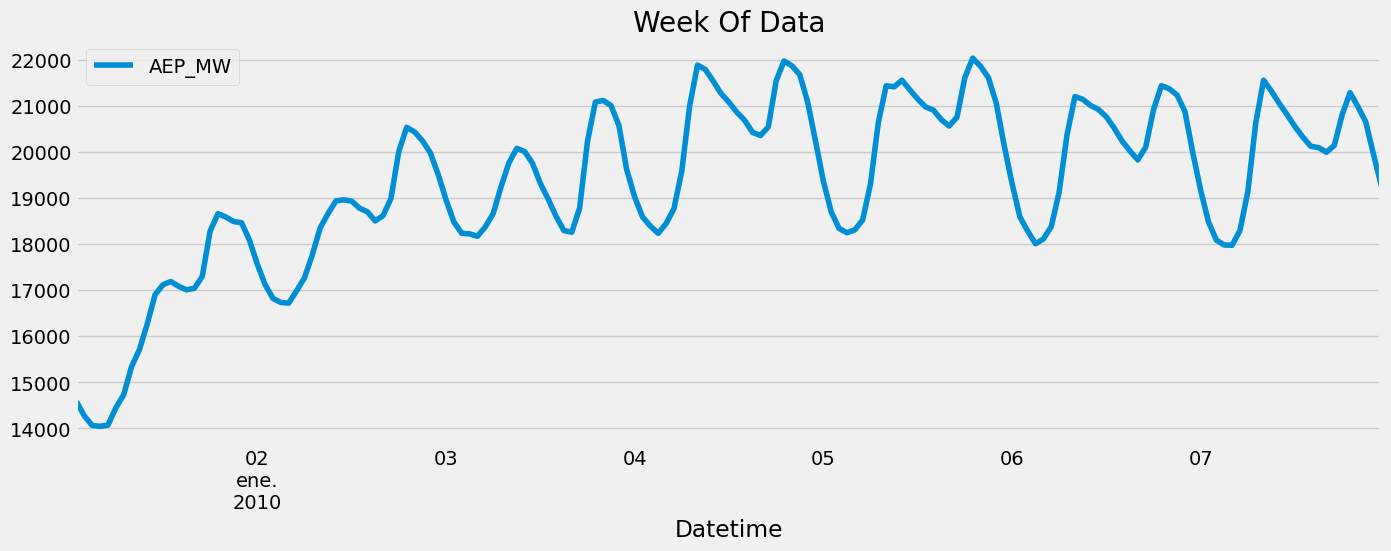

In [8]:

# Visualización de un fragmento semanal de los datos.
# Este gráfico permite observar el comportamiento detallado de la serie temporal 
# durante una semana específica (del 1 al 8 de enero de 2010), facilitando el análisis a corto plazo.
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()


In [9]:

def create_features(df):
    """
    Genera variables temporales a partir del índice de fechas del DataFrame.
    Estas características son útiles para modelos de series de tiempo, ya que capturan patrones
    estacionales y cíclicos relacionados con la hora, el día, el mes, etc.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df


df = create_features(df)

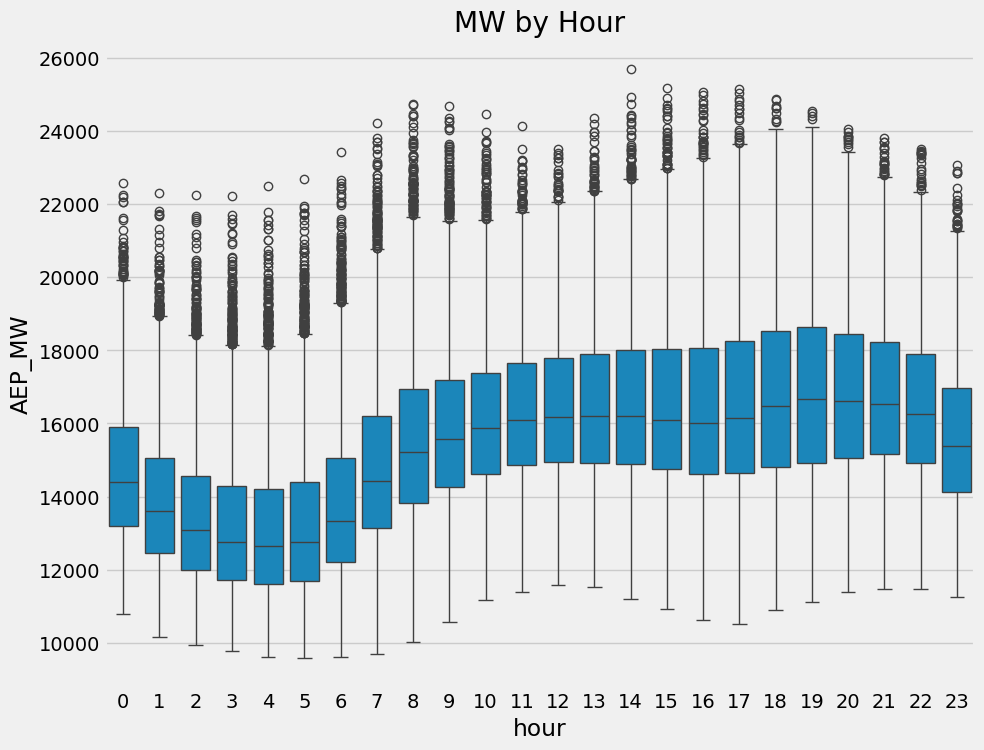

In [ ]:
#visualizar cómo varía la demanda de energía 
#(en megavatios, MW) a lo largo de las horas del día:

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

El grafico nos muestra entonces, una mediana (línea central).
los cuartiles (caja), los rangos típicos (bigotes) y los valores atípicos (puntos fuera de los bigotes).

Es útil para identificar las horas con mayor variabilidad en la demanda de la energía, determinar las horas pico de consumo y los comportamientos anómalos.

C:\Users\NKD\AppData\Local\Temp\ipykernel_16416\1824668288.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')


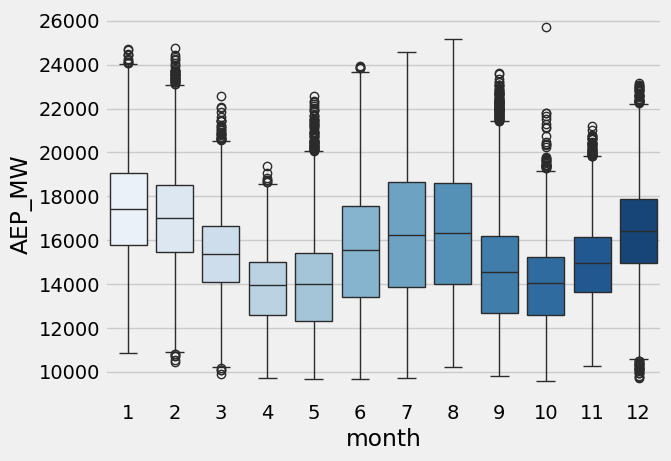

In [13]:
#Aquí podremos ver una visualización mensual de la información.
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

C:\Users\NKD\AppData\Local\Temp\ipykernel_16416\1506876030.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='year', y='AEP_MW', palette='Blues')


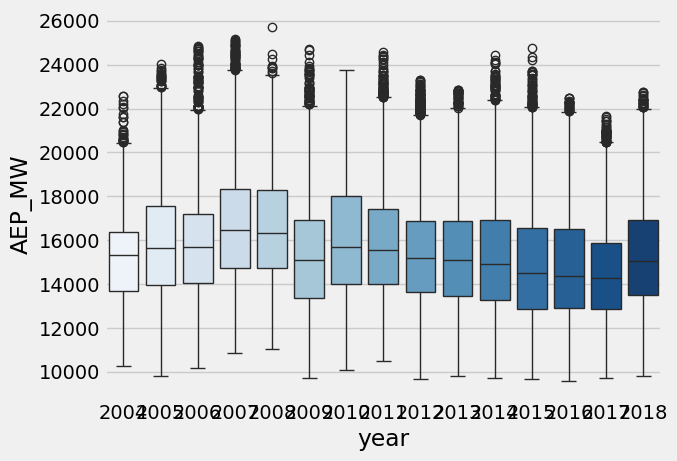

In [15]:
#Esta, una visualización anual.
# fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='AEP_MW', palette='Blues')
ax.set_title('MW by year')
plt.show()

La visualización del consumo periódico de energía es una herramienta clave para extraer patrones útiles que pueden guiar la toma de decisiones en sectores como compañías aseguradoras, eléctricas y otras entidades involucradas en la cadena de distribución.

Además, este análisis visual es fundamental para el desarrollo de modelos predictivos, ya que permite identificar comportamientos recurrentes y estacionales en los datos, lo cual mejora la precisión de los algoritmos de predicción.